# Water Pumps: Preprocessing
## Business Problem:
Tanzania is a developing country and access to water is very important for the health of the population. For this reason, it is vital that all water pumps are properly working. Currently, the only way to monitor pump working status is by physically visiting the site. This is time consuming and costly. Therefore, a more intelligent solution to monitor water pump status is desirable.

This project will address the following question: How can the government of Tanzania improve water pump maintenance by knowing the pump functional status in advance?
    
## Import libraries

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Load Dataset
Load the dataset after it has been modified during EDA.

In [2]:
df = pd.read_csv('../data/clean/eda_data.csv', parse_dates=['date_recorded'], infer_datetime_format=True)

## Preprocessing
### Data types
Review the datatypes in the dataset.

In [3]:
all_data_types = df.dtypes
unique_data_types = all_data_types.unique()
print(unique_data_types)

[dtype('O') dtype('<M8[ns]') dtype('int64') dtype('float64')]


In [4]:
print(df.select_dtypes(include=['O']).columns.tolist())

['status_group']


The data types consist of *object*, which is the *status_group* column, datetime, int and float.

## Model Evaluation
The dataset is now ready for modeling. I will try several models to determine which one performs the best.

## Train/Test Split
Before modeling, I will split the dataset into a training set and test set.

In [5]:
X = df.drop(columns=['status_group', 'date_recorded'])
y = df['status_group']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42)

### Model 1: Logistic Regression
I will first try a very simple logistic regression model.

**Parameters:**
* Algorithm: `LogisticRegression()`
* Preprocessing: `MinMaxScaler()`

In [7]:
estimators_1 = [('min_max', MinMaxScaler()), ('log_reg', LogisticRegression())]
pipe_1 = Pipeline(estimators_1)
pipe_1.fit(X_train, y_train)
pipe_1.score(X_test, y_test)

/Users/dave/anaconda3/envs/springboard/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7544647748438699

Using the recommendations from this error message, I will try a different solver.

In [8]:
estimators_2 = [('min_max', MinMaxScaler()), ('log_reg', LogisticRegression(solver='saga'))]
pipe_2 = Pipeline(estimators_2)
pipe_2.fit(X_train, y_train)
print(f'The training score is: {pipe_2.score(X_train, y_train):0.3%}.')
print(f'The test score is: {pipe_2.score(X_test, y_test):0.3%}.')

The training score is: 76.845%.
The test score is: 75.457%.


**Observations:**
The similarity in scores seems to indicate that over fitting is not a problem. But, more analysis is needed to determine how good the classification of each target class is.

### Confusion Matrix
Let's compare the performance of the model by creating a confusion matrix for both the training and test sets.

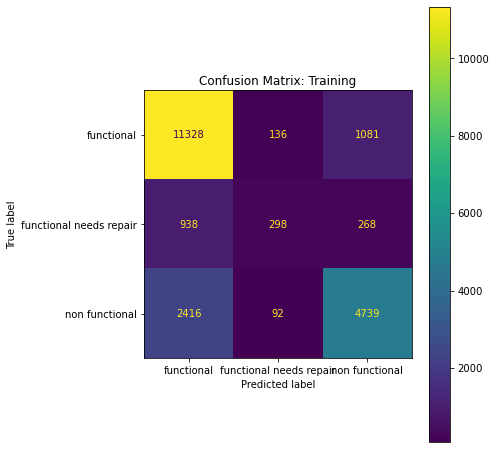

In [9]:
fix, ax = plt.subplots(figsize=(6, 8))
plot_confusion_matrix(pipe_2, X_train, y_train, ax=ax)
ax.set_title('Confusion Matrix: Training')
plt.show()

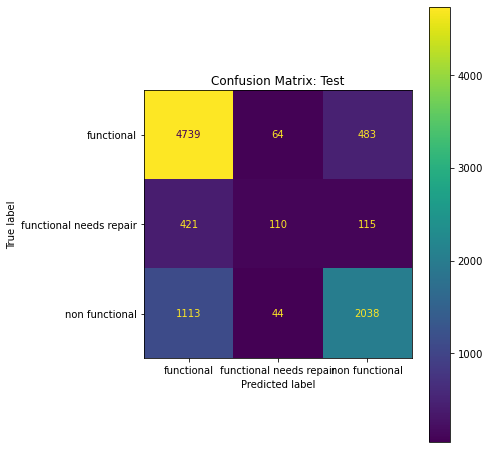

In [10]:
fix, ax = plt.subplots(figsize=(6, 8))
plot_confusion_matrix(pipe_2, X_test, y_test, ax=ax)
ax.set_title('Confusion Matrix: Test')
plt.show()

**Observations:**
Visually, the model appears to perform best on the *functional* class and worse on the *functional needs repair* class. Intuitively this makes sense since *functional* has the largest class membership, while *functional needs repair* has the lowest class membership.

### Classification Report
Metrics for each class predicted by the model can be determined by using ``

In [11]:
y_pred_train_2 = pipe_2.predict(X_train)
y_pred_2 = pipe_2.predict(X_test)

In [12]:
print(classification_report(y_train, y_pred_train_2))

                         precision    recall  f1-score   support

             functional       0.77      0.90      0.83     12545
functional needs repair       0.57      0.20      0.29      1504
         non functional       0.78      0.65      0.71      7247

               accuracy                           0.77     21296
              macro avg       0.71      0.59      0.61     21296
           weighted avg       0.76      0.77      0.75     21296



In [13]:
print(classification_report(y_test, y_pred_2))

                         precision    recall  f1-score   support

             functional       0.76      0.90      0.82      5286
functional needs repair       0.50      0.17      0.25       646
         non functional       0.77      0.64      0.70      3195

               accuracy                           0.75      9127
              macro avg       0.68      0.57      0.59      9127
           weighted avg       0.74      0.75      0.74      9127



**Observations:**
The model performance on the train and test sets is quite similar. The test set only performs a few hundredths of a point worse across all classification report metrics. Therefore, I can conclude that there is no overfitting.

### Model 2 - Feature Importance
I will now explore feature importance. But, first I need to understand the coefficients for this model.

In [14]:
multi_class_param = pipe_2.get_params()['log_reg__multi_class']
print(f'The multi_class param is {multi_class_param}.')

The multi_class param is auto.


According to the sklearn documentation, if multi_class is set to 'auto' and the number of classes is greater than two, the model defaults to a multi_class value of 'multi_nominal'. The means that for each sample prediction a separate probability is computed for each class. The class with the highest probability is then assigned as the predicted class for that sample.

Now, I will explore the shape of the coefficents array.

In [15]:
pipe_2.named_steps['log_reg'].coef_.shape

(3, 230)

The coefficents consist of three columns, one for each class, and 230 rows, the number of features in the dataset.

Let's determine which column index corresponds to which class.

In [16]:
for i, class_name in enumerate(pipe_2.named_steps['log_reg'].classes_):
    print(f" * '{class_name}' class corresponds to index {i}.")

 * 'functional' class corresponds to index 0.
 * 'functional needs repair' class corresponds to index 1.
 * 'non functional' class corresponds to index 2.


Now, I will determine the important features for each class in the target variable, as determined by the model.

In [17]:
def gather_feature_importance(X, model, step_name, top_n_features=10):
    feature_importance_dict = {}
    for i in range(len(model.named_steps[step_name].coef_)):
        feature_importance = pd.DataFrame({'features': X.columns.to_list(), 'coefs': model.named_steps[step_name].coef_[i]})
        feature_importance['abs_coefs'] = np.abs(feature_importance['coefs'])
        feature_importance = feature_importance.sort_values(by='abs_coefs', ascending=False).iloc[:top_n_features, :]
        feature_importance_dict[model.named_steps[step_name].classes_[i]] = feature_importance
    return feature_importance_dict

In [18]:
feature_importance_dict = gather_feature_importance(X, pipe_2, 'log_reg')

In [19]:
for class_name, feature_importance in feature_importance_dict.items():
    print(f'Class Name: {class_name}')
    display(feature_importance)
    print('')

Class Name: functional


,features,coefs,abs_coefs
214,quantity_group_enough,2.364617,2.364617
217,quantity_group_unknown,2.055882,2.055882
216,quantity_group_seasonal,2.033458,2.033458
215,quantity_group_insufficient,2.011633,2.011633
229,waterpoint_type_other,-1.413090,1.413090
46,lga_Kilindi,1.275036,1.275036
57,lga_Liwale,1.141513,1.141513
87,lga_Pangani,-1.025134,1.025134
1,longitude,1.010724,1.010724
84,lga_Ngorongoro,-0.997525,0.997525



Class Name: functional needs repair


,features,coefs,abs_coefs
28,lga_Arusha Urban,1.643077,1.643077
63,lga_Masasi,1.515573,1.515573
34,lga_Hanang,-1.408456,1.408456
71,lga_Moshi Rural,1.293268,1.293268
105,lga_Tunduru,1.292604,1.292604
53,lga_Kiteto,1.184799,1.184799
31,lga_Bariadi,1.150758,1.150758
25,region_Shinyanga,1.150758,1.150758
215,quantity_group_insufficient,1.146567,1.146567
214,quantity_group_enough,1.094901,1.094901



Class Name: non functional


,features,coefs,abs_coefs
214,quantity_group_enough,-3.459518,3.459518
215,quantity_group_insufficient,-3.158200,3.158200
216,quantity_group_seasonal,-3.047061,3.047061
217,quantity_group_unknown,-2.135632,2.135632
71,lga_Moshi Rural,-2.040404,2.040404
63,lga_Masasi,-1.673254,1.673254
28,lga_Arusha Urban,-1.526618,1.526618
95,lga_Singida Rural,-1.179880,1.179880
9,basin_Rufiji,1.084411,1.084411
47,lga_Kilolo,1.076202,1.076202


**Observations:**
* Class: functional
    * The feature contributing most positively is *quantity_group_enough*.
    * The feature contributing most negatively is *waterpoint_type_other*.
* Class: functional needs repair
    * The feature contributing most positively is *lga_Arusha Urban*.
    * The feature contributing most negatively is *lga_Hanang*.
* Class: non functional
    * There is not dominant, positive feature.
    * The feature contributing most negatively is *quantity_group_enough*.
    
The amount of water at a pump appears to be strongly related to whether the pump is functional or not.

## Summary
During pre-processing, I have determined the following items:
* I created a preliminary logistic regression model with an accuracy of 77% on the training set and 76% on the test.
* The classification metrics for the training and test sets are similar, with a fit on the test set that is slightly worse.
* The similarity in metrics between the training and test sets indicates that over fitting is not a problem.
* An analysis of feature importance indicates that the amount of water at a pump appears to be strongly related to whethere the pump is functional or not.